In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import corner
import numpy as np

In [11]:
from torsionfit.toy_model import ToyModel

original torsion
<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>


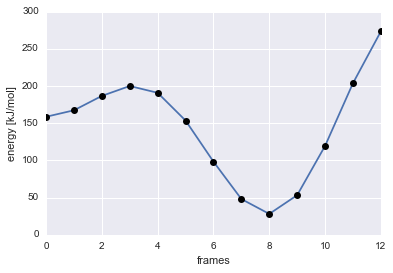

In [12]:
toy = ToyModel()
plt.plot(toy.synthetic_energy)
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.savefig('qm.pdf')


In [13]:
print(toy.true_value)
print(toy.initial_value)


<DihedralTypes [<DihedralType; phi_k=16.932, per=3, phase=180.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=18.953, per=2, phase=0.000,  scee=1.000, scnb=1.000>]>
<DihedralTypes [<DihedralType; phi_k=14.558, per=6, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=11.509, per=1, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.058, per=4, phase=180.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.000, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.000, per=3, phase=0.000,  scee=1.000, scnb=1.000>]>


In [14]:
# sample
sampler = MCMC(toy.model.pymc_parameters)
sampler.sample(iter=1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 14.9 sec

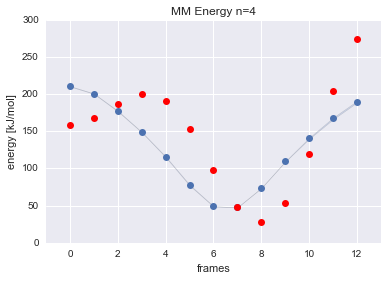

In [15]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, 'o', color='r')
plt.title('MM Energy n=4')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.savefig('n_4_mm_fit.pdf')

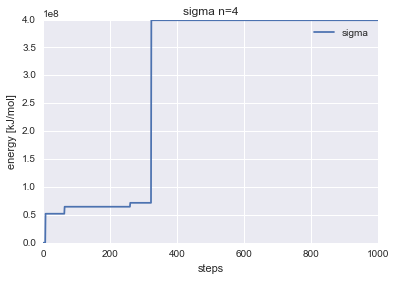

In [16]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.title('sigma n=4')

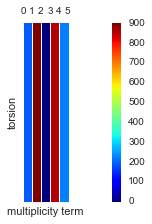

In [18]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 1000, 100, 'test_2.png')


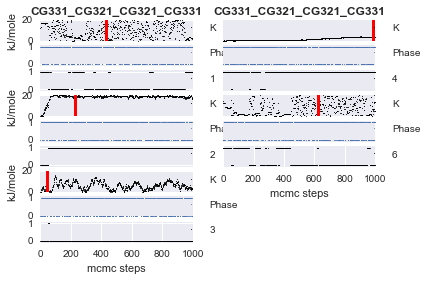

In [19]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0)

In [20]:
data = np.stack((sampler.CG331_CG321_CG321_CG331_1_K.trace[100:],
                sampler.CG331_CG321_CG321_CG331_2_K.trace[100:], sampler.CG331_CG321_CG321_CG331_3_K.trace[100:], 
                sampler.CG331_CG321_CG321_CG331_4_K.trace[100:], sampler.CG331_CG321_CG321_CG331_6_K.trace[100:]), axis=1)

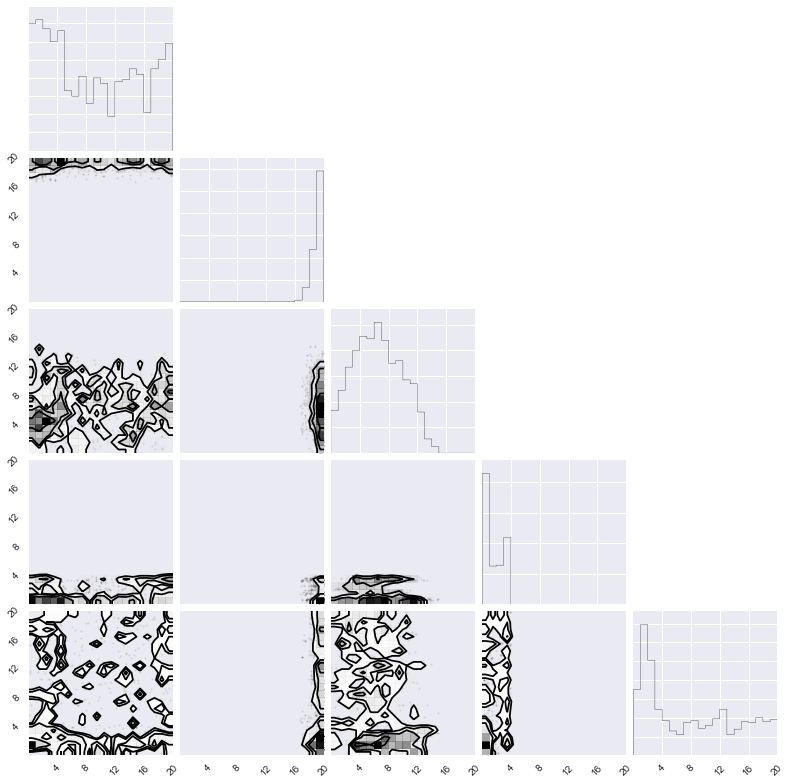

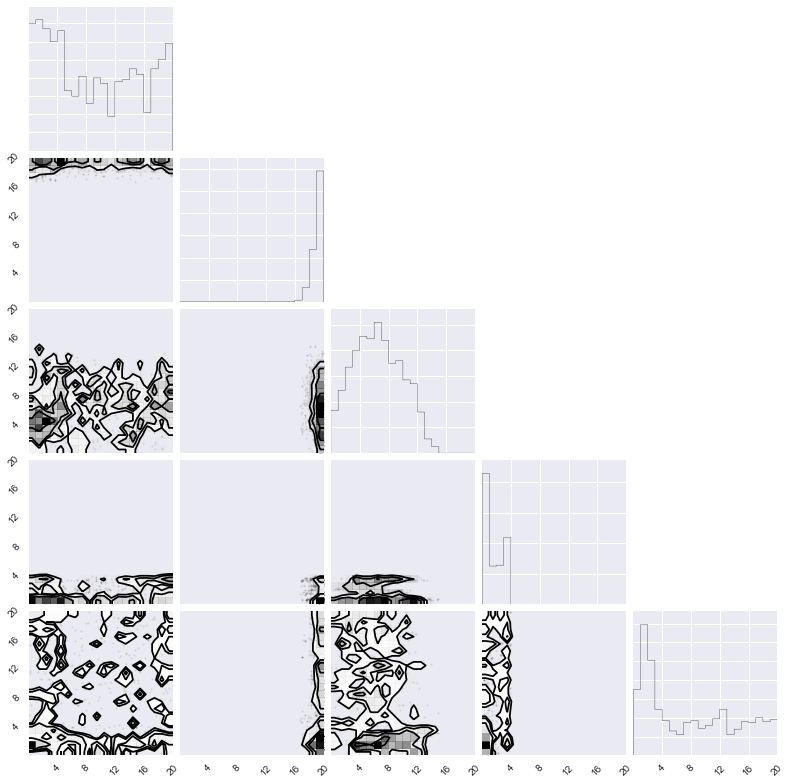

In [21]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])